In [6]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np


'''An SE(A)IR model described the paper:
Bayesian particle filter algorithm for learning epidemic dynamics 
Calvetti et. al. '''

'''The model dynamics are designed for COVID, with SEAIRD dynamics. Given the absence of additional time series information, 
they combine the E and A compartments into a single compartment denoted E(A)'''


beta_par = {'beta_0':0.4,'beta_inf':0.1,'T':20,'tau':5} #hyperparameters for the functional form of beta

'''Functional beta'''
def beta(t,beta_par):

    if(t<beta_par['T']):
        return beta_par['beta_0']

    return beta_par['beta_inf'] + (beta_par['beta_0'] - beta_par['beta_inf']) * np.exp(-(t-beta_par['T'])/beta_par['tau'])
    

'''Model parameters'''
params = {'beta':lambda t: beta(t,beta_par),'eta':1/7,'gamma':1/14,'mu':0.004,'N_p':100_000, 'q':0.1}


def RHS(t,y,par): 
    S,E,I,R,_ = y
    dS = - par['beta'](t) * ((E + par['q'] * I)/par['N_p']) * S
    dE =   par['beta'](t) * ((E + par['q'] * I)/par['N_p']) * S - par['eta']*E - par['gamma'] * E
    dI = par['eta'] * E - par['gamma'] * I - par['mu'] * I
    dR = par['gamma'] * E + par['gamma'] * I

    d_newI = par['eta'] * E

    return np.array([dS,dE,dI,dR,d_newI])





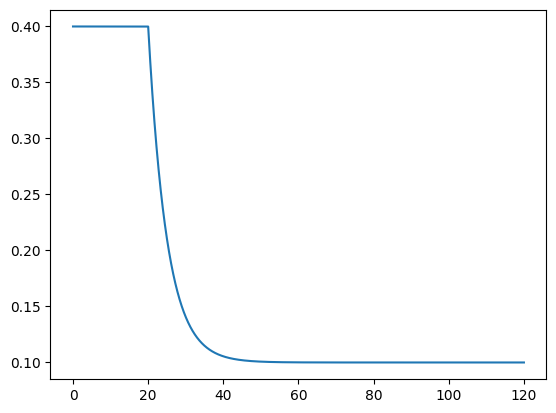

In [7]:
'''Plots the functional form of beta(t), negative exponential'''

beta_ts = np.linspace(0,120,120000)

betas = []
for i in range(np.shape(beta_ts)[0]):
    betas.append(beta(beta_ts[i],beta_par))

plt.plot(beta_ts,np.array(betas))


In [8]:
t_span = [0,120]
initial_infected = 2
y0 = [params['N_p'] - initial_infected,initial_infected,0,0,0]

'''Default solver is RK-45

Solves the ODE system for Protocol A, gamma = 1/14, eta = 1/7

'''
sol = solve_ivp(fun=lambda t,y: RHS(t,y,params),t_span = t_span,y0 = y0,t_eval = np.linspace(0,120,120))





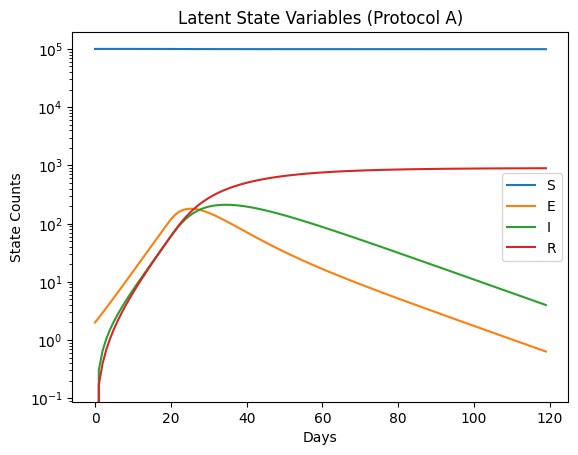

In [9]:
'''Plotting for the state variables'''

plt.yscale('log')
plt.xlabel('Days')
plt.ylabel('State Counts')
plt.title('Latent State Variables (Protocol A)')
labels = ['S','E','I','R']
for i in range(4):
    plt.plot(sol.y[i,:],label = labels[i])
plt.legend()



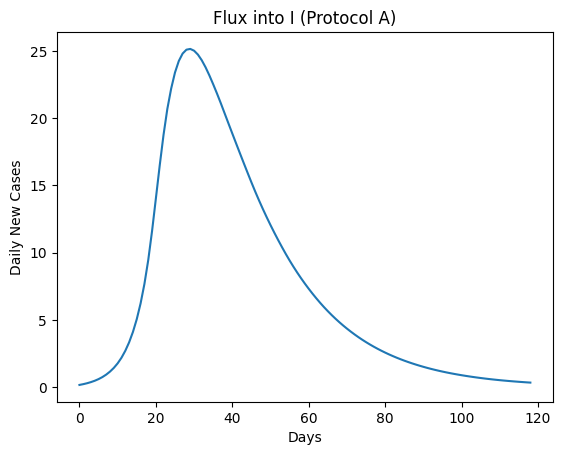

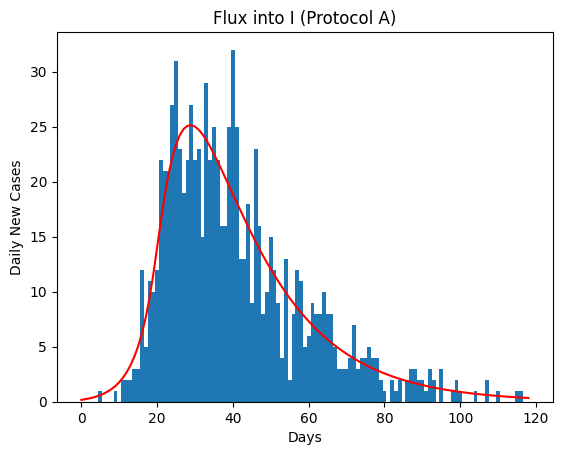

In [10]:
import pandas as pd

'''Plotting for the flux ->I'''
plt.xlabel('Days')
plt.ylabel('Daily New Cases')
plt.title('Flux into I (Protocol A)')
plt.plot(np.diff(sol.y[3,:]))
plt.show()

'''Plotting for the Poisson samples centered at the flux ->I'''

flux = np.diff(sol.y[3,:])
rng = np.random.default_rng()

sim_data = rng.poisson(flux) 

pd.DataFrame(sim_data).to_csv('../datasets/calvetti_sim_data_protocol_A.csv')

plt.xlabel('Days')
plt.ylabel('Daily New Cases')
plt.title('Flux into I (Protocol A)')
plt.bar(x=np.arange(0,119),height = sim_data,width=1)
plt.plot(flux,zorder=2,color='red')
plt.show()




The ->I flux from Calvetti et. al.  

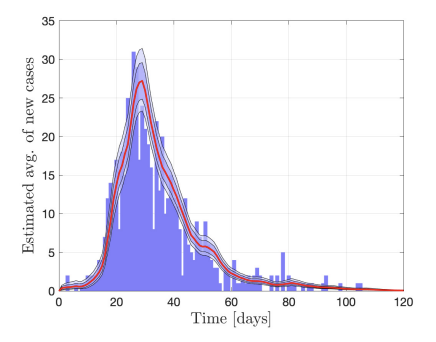